# Exponential Smoothing Model (ETS)

The **ETS** (Error, Trend, Seasonality) framework is a powerful and flexible approach to exponential smoothing for time series forecasting. ETS models are characterized by three key components: the type of error (additive or multiplicative), the type of trend (none, additive, multiplicative, or damped), and the type of seasonality (none, additive, or multiplicative). This systematic framework provides a unified approach to exponential smoothing methods, encompassing classic techniques like simple exponential smoothing, Holt's linear method, and Holt-Winters seasonal methods.

Unlike traditional models that rely on rigid differencing transformations, ETS uses a state-space formulation where the level, trend, and seasonal components are recursively updated at each time step. This makes ETS models highly interpretable while maintaining flexibility to handle various patterns in time series data.

**The ETS Framework**

ETS models maintain internal state variables that evolve over time through smoothing equations:

* **Level ($\ell_t$)**: The baseline value of the series at time $t$.
* **Trend ($b_t$)**: The rate of change or growth pattern.
* **Seasonal ($s_t$)**: Repeating patterns with a fixed period $m$.

Each component can be modeled as additive or multiplicative, resulting in different model behaviors.

**Error, Trend, and Seasonality Components**

The model specification uses three-letter notation (e.g., "AAN", "MAM"):

**First Letter - Error Type:**
* **A (Additive)**: Errors are independent of the series level
* **M (Multiplicative)**: Errors scale proportionally with the series level

**Second Letter - Trend Type:**
* **N (None)**: No trend component
* **A (Additive)**: Linear trend
* **M (Multiplicative)**: Exponential growth trend
* **Add damping**: Use `damped=True` to dampen the trend over time

**Third Letter - Seasonal Type:**
* **N (None)**: No seasonal pattern
* **A (Additive)**: Constant seasonal effect
* **M (Multiplicative)**: Seasonal effect proportional to level


**ETS vs. ARIMA**

While both methods aim to predict future values based on history, they approach the problem from fundamentally different angles.

| Feature | ARIMA (Auto-Regressive Integrated Moving Average) | ETS (Error, Trend, Seasonality) |
| :--- | :--- | :--- |
| **Approach** | **Differencing + ARMA.** Achieves stationarity through differencing, then fits AR and MA terms. | **State-Space Smoothing.** Recursively updates level, trend, and seasonal states with exponential smoothing. |
| **Model Form** | **Linear combination of past values and errors** (after differencing). | **Explicit state equations** for level, trend, and seasonality with additive or multiplicative structure. |
| **Automation** | **Semi-Manual.** Requires order selection ($p,d,q$) though auto.ARIMA algorithms exist. | **Fully Automated.** Model selection ('ZZZ') systematically searches over all valid ETS models. |


<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:600;">
  <span style="margin-right:6px; font-size:22px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0; color:inherit;">
  
  The Python implementation of the ETS algorithm in skforecast follows the state-space framework described in Hyndman et al. (2008) and is based on the Julia package <a href="https://taf-society.github.io/Durbyn.jl/dev/">Durbyn.jl</a> developed by Resul Akay.
</p>

</div>

## ETS model theory

ETS models use a state-space framework with two core equations: an observation equation relating observations to states, and state transition equations describing how states evolve.

### Additive Error State-Space Form

For additive error models, the state-space representation is:

**Observation equation:**
$$Y_t = H x_{t-1} + \varepsilon_t$$

**State equation:**
$$x_t = F x_{t-1} + G \varepsilon_t$$

where $\varepsilon_t \sim WN(0, \sigma^2)$ is white noise, $x_t$ is the state vector containing level, trend, and seasonal components, and $H$, $F$, $G$ are system matrices that depend on the specific ETS model.

**Forecast mean and variance at horizon $h$:**

$$\mu_n(h) = H F^{h-1} x_n$$

$$v_n(h) = \sigma^2 \left(1 + \sum_{j=1}^{h-1} (H F^{j-1} G)^2\right)$$

### Simple Exponential Smoothing (ANN)

For series with no trend or seasonality:

**Innovations state-space form (additive errors):**
$$Y_t = \ell_{t-1} + \varepsilon_t$$
$$\ell_t = \ell_{t-1} + \alpha \varepsilon_t$$

where $\ell_t$ is the level at time $t$, $\alpha \in (0,1)$ is the smoothing parameter, and $\varepsilon_t \sim WN(0, \sigma^2)$.

**Component form:**
$$\ell_t = \alpha Y_t + (1-\alpha) \ell_{t-1}$$

**Forecast function:**
$$\hat{Y}_{n+h|n} = \ell_n \text{ for all } h \geq 1$$

**Forecast variance:**
$$\sigma^2_h = \sigma^2[1 + \alpha^2(h-1)]$$

**Multiplicative Error Form (MNN):**
$$Y_t = \ell_{t-1}(1 + \varepsilon_t)$$
$$\ell_t = \ell_{t-1}(1 + \alpha \varepsilon_t)$$

Point forecasts are identical to the additive form, but prediction intervals scale with the level.

### Holt's Linear Trend Method (AAN)

For series with additive trend:

**Innovations state-space form (additive errors):**
$$Y_t = \ell_{t-1} + b_{t-1} + \varepsilon_t$$
$$\ell_t = \ell_{t-1} + b_{t-1} + \alpha \varepsilon_t$$
$$b_t = b_{t-1} + \beta \varepsilon_t$$

where $\ell_t$ is the level, $b_t$ is the trend, $\alpha, \beta \in (0,1)$ are smoothing parameters, and $\varepsilon_t \sim WN(0, \sigma^2)$. Note that $\beta = \alpha \beta^*$ where $\beta^*$ is the trend smoothing parameter often used in the component form.

**Component form:**
* Level: $\ell_t = \alpha Y_t + (1-\alpha)(\ell_{t-1} + b_{t-1})$
* Trend: $b_t = \beta^*(\ell_t - \ell_{t-1}) + (1-\beta^*) b_{t-1}$

**Forecast function:**
$$\hat{Y}_{n+h|n} = \ell_n + h \cdot b_n$$

**Forecast variance:**
$$\sigma^2_h = \sigma^2\left[1 + (h-1)\left\{\alpha^2 + \alpha\beta h + \frac{1}{6}\beta^2 h(2h-1)\right\}\right]$$

### Damped Trend

**Innovations state-space form (additive errors):**
$$Y_t = \ell_{t-1} + \phi b_{t-1} + \varepsilon_t$$
$$\ell_t = \ell_{t-1} + \phi b_{t-1} + \alpha \varepsilon_t$$
$$b_t = \phi b_{t-1} + \beta \varepsilon_t$$

where $\phi \in (0,1]$ is the damping parameter.

**Component form:**
* Level: $\ell_t = \alpha Y_t + (1-\alpha)(\ell_{t-1} + \phi b_{t-1})$
* Trend: $b_t = \beta^*(\ell_t - \ell_{t-1}) + (1-\beta^*) \phi b_{t-1}$

**Forecast function:**
$$\hat{Y}_{n+h|n} = \ell_n + (\phi + \phi^2 + \cdots + \phi^h) b_n$$

The damping parameter controls how quickly the trend dampens:
* $\phi = 1$: Standard Holt (no damping)
* $\phi < 1$: Damped trend (trend flattens out in forecasts)

Advantages of damped trend:
* More realistic long-term forecasts
* Prevents unbounded linear extrapolation
* Often improves forecast accuracy for horizons $h > 10$

### Holt-Winters Seasonal Methods

**Additive Seasonality (AAA) - Component form:**

$$\hat{Y}_{t+h|t} = \ell_t + hb_t + s_{t+h-m(k+1)}$$
$$\ell_t = \alpha(Y_t - s_{t-m}) + (1-\alpha)(\ell_{t-1} + b_{t-1})$$
$$b_t = \beta^*(\ell_t - \ell_{t-1}) + (1-\beta^*) b_{t-1}$$
$$s_t = \gamma(Y_t - \ell_{t-1} - b_{t-1}) + (1-\gamma) s_{t-m}$$

where $m$ is the seasonal period and $k = \lfloor (h-1)/m \rfloor$.

**Multiplicative Seasonality (MAM) - Component form:**

$$\hat{Y}_{t+h|t} = (\ell_t + hb_t) s_{t+h-m(k+1)}$$
$$\ell_t = \alpha \frac{Y_t}{s_{t-m}} + (1-\alpha)(\ell_{t-1} + b_{t-1})$$
$$b_t = \beta^*(\ell_t - \ell_{t-1}) + (1-\beta^*) b_{t-1}$$
$$s_t = \gamma \frac{Y_t}{(\ell_{t-1} + b_{t-1})} + (1-\gamma) s_{t-m}$$

### Multiplicative Error Form

For multiplicative error models, the innovations state-space formulation has:

**Observation:**
$$Y_t = \mu_t(1 + \varepsilon_t)$$

where $\mu_t$ is the one-step-ahead forecast and $\varepsilon_t \sim WN(0, \sigma^2)$.

**Key property:** Point forecasts are the same as additive-error models, but prediction intervals scale with the level.

**Examples:**

* **MNN** (no trend, no seasonality):
$$Y_t = \ell_{t-1}(1 + \varepsilon_t)$$
$$\ell_t = \ell_{t-1}(1 + \alpha \varepsilon_t)$$

* **MAN** (additive trend):
$$Y_t = (\ell_{t-1} + b_{t-1})(1 + \varepsilon_t)$$
$$\ell_t = (\ell_{t-1} + b_{t-1})(1 + \alpha \varepsilon_t)$$
$$b_t = b_{t-1} + \beta(\ell_{t-1} + b_{t-1}) \varepsilon_t$$

### Admissible Parameter Space

For stability and forecastability, ETS models have admissible parameter regions:

**ANN / MNN:**
$$0 < \alpha < 2$$

**AAN / MAN:**
$$0 < \alpha < 2, \quad 0 < \beta < 4 - 2\alpha$$

**ADN (damped additive trend):**
$$0 < \phi \leq 1, \quad 1 - \frac{1}{\phi} < \alpha < 1 + \frac{1}{\phi}$$
$$\alpha(\phi - 1) < \beta < (1 + \phi)(2 - \alpha)$$

In practice, $\alpha, \beta^*, \gamma$ are typically constrained to $(0,1)$ for conventional exponential smoothing behavior, though the admissible regions allow for broader ranges that still ensure stable forecasts.

Admissible regions do not depend on whether errors are additive or multiplicative.

### Model Selection

ETS models are typically estimated by maximizing the likelihood function. For model selection, information criteria are used:

* **AIC** (Akaike Information Criterion): $\text{AIC} = -2\log L + 2k$
* **AICc** (Corrected AIC): $\text{AICc} = \text{AIC} + \frac{2k(k+1)}{n-k-1}$ (recommended for small samples)
* **BIC** (Bayesian Information Criterion): $\text{BIC} = -2\log L + k\log n$

where $k$ is the number of parameters and $n$ is the number of observations.

The log-likelihood depends on the error type:

**Additive errors:**
$$\log L = -\frac{n}{2}\log\left(\frac{1}{n}\sum_{t=1}^{n}e_t^2\right)$$

**Multiplicative errors:**
$$\log L = -\frac{n}{2}\log\left(\frac{1}{n}\sum_{t=1}^{n}e_t^2\right) - \sum_{t=1}^{n}\log|\hat{y}_t|$$

Ref: Hyndman, R.J., Koehler, A.B., Ord, J.K., Snyder, R.D. (2008) *Forecasting with exponential smoothing: the state space approach*, Springer-Verlag: New York. [exponentialsmoothing.net](http://www.exponentialsmoothing.net)

## Libraries and data

In [2]:
# Libraries
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.stats import Ets
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=False)
data = data.loc[:'1990-01-01 00:00:00']
y = data['Gasolinas'].rename('y').rename_axis('date')
y

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 5 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
1969-05-01    206259.1523
                 ...     
1989-09-01    687649.2852
1989-10-01    669889.1602
1989-11-01    601413.8867
1989-12-01    663568.1055
1990-01-01    610241.2461
Freq: MS, Name: y, Length: 253, dtype: float64

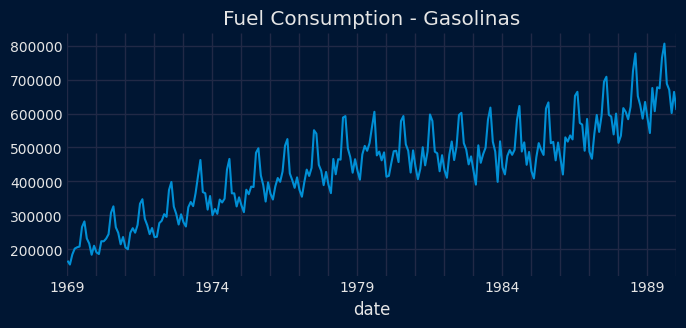

In [4]:
# Plot series
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
y.plot(ax=ax)
ax.set_title('Fuel Consumption - Gasolinas')
plt.show()

## ETS and AutoETS

**Skforecast** provides the class [`Ets`](https://skforecast.org/latest/api/stats#ets) to facilitate the creation of ETS models in Python, allowing users to easily fit and forecast time series data using this approach.

The `Ets` class provides flexible control over model specification and parameter estimation through several key arguments:

**Model Specification**

* `model` (str, default="ZZZ"): Three-letter code specifying the model structure:
  * First letter (Error): `A` (Additive), `M` (Multiplicative), or `Z` (Auto-select)
  * Second letter (Trend): `N` (None), `A` (Additive), `M` (Multiplicative), or `Z` (Auto-select)
  * Third letter (Season): `N` (None), `A` (Additive), `M` (Multiplicative), or `Z` (Auto-select)
  * Examples: `"ANN"` (simple exponential smoothing), `"AAN"` (Holt's linear trend), `"AAA"` (additive Holt-Winters)
  * Use `"ZZZ"` for fully automatic model selection

* `m` (int, default=1): Seasonal period (e.g., 12 for monthly data with yearly seasonality, 4 for quarterly)

* `damped` (bool or None, default=None): Enable damped trend to prevent unbounded extrapolation
  * `True`: Use damped trend
  * `False`: Use standard (non-damped) trend
  * `None`: Try both when `model="ZZZ"` (automatic selection)

**Fixed Parameters (optional)**

If specified, these parameters are held fixed instead of being estimated:

* `alpha` (float): Level smoothing parameter (0 < α < 1)
* `beta` (float): Trend smoothing parameter (0 < β < α)
* `gamma` (float): Seasonal smoothing parameter (0 < γ < 1-α)
* `phi` (float): Damping parameter (0 < φ < 1)

**Automatic Model Selection (model="ZZZ")**

* `seasonal` (bool, default=True): Allow seasonal models in automatic selection
* `trend` (bool or None, default=None): Control trend in model search
  * `None`: Try both trending and non-trending models
  * `True`: Only try models with trend
  * `False`: Only try models without trend
* `ic` (str, default="aicc"): Information criterion for model selection
  * `"aic"`: Akaike Information Criterion
  * `"aicc"`: Corrected AIC (recommended for small samples)
  * `"bic"`: Bayesian Information Criterion
* `allow_multiplicative` (bool, default=True): Allow multiplicative errors and seasonality
* `allow_multiplicative_trend` (bool, default=False): Allow multiplicative trend (generally not recommended)

**Transformations**

* `lambda_param` (float or None): Box-Cox transformation parameter
  * `None`: No transformation
  * `0`: Log transformation
  * `1`: No transformation
  * Other values: Box-Cox transformation
* `lambda_auto` (bool, default=False): Automatically select optimal Box-Cox parameter
* `bias_adjust` (bool, default=True): Apply bias adjustment when back-transforming forecasts

**Parameter Constraints**

* `bounds` (str, default="both"): Type of parameter bounds
  * `"usual"`: Traditional bounds (0 < α, β*, γ < 1)
  * `"admissible"`: Broader stability bounds (e.g., 0 < α < 2 for ANN)
  * `"both"`: Check both usual and admissible bounds

**Common Configuration Examples**

| Use Case | Configuration | Description |
|:---------|:--------------|:------------|
| Automatic (unrestricted) | `Ets(m=12, model="ZZZ")` | Fully automatic selection from all valid models |
| Automatic (conservative) | `Ets(m=12, model="ZZZ", allow_multiplicative=False)` | Only additive error and seasonality models |
| Simple exponential smoothing | `Ets(model="ANN")` | No trend, no seasonality (flat forecast) |
| Holt's linear trend | `Ets(model="AAN")` | Additive trend, no seasonality |
| Damped trend | `Ets(model="AAN", damped=True)` | Dampened trend for conservative long-term forecasts |
| Additive Holt-Winters | `Ets(model="AAA", m=12)` | Additive trend and seasonality |
| Multiplicative Holt-Winters | `Ets(model="MAM", m=12)` | Multiplicative errors, additive trend, multiplicative seasonality |
| Seasonal no trend | `Ets(model="ANA", m=12)` | Additive seasonality without trend |
| Non-seasonal with Box-Cox | `Ets(model="AAN", lambda_auto=True)` | Automatic variance stabilization transformation |
| Fixed smoothing parameters | `Ets(model="AAN", alpha=0.2, beta=0.1)` | Manual parameter specification (not estimated) |

### How Automatic Model Selection Works

When `model="ZZZ"` is specified, the ETS class performs automatic model selection following this process:

1. **Candidate Model Generation**: Constructs a set of candidate models by combining different error types (A/M), trend types (N/A/M), and seasonal types (N/A/M), subject to constraints:
   - By default, multiplicative trend is excluded (`allow_multiplicative_trend=False`) as it can be numerically unstable
   - Certain combinations are invalid (e.g., additive error with multiplicative components)
   - If data has fewer observations than the seasonal period `m`, only non-seasonal models are considered
   - For high-frequency data (`m > 24`), seasonality is automatically disabled

2. **Model Estimation**: Each candidate model is fitted to the data using maximum likelihood estimation with parameter bounds checking (`bounds="both"` by default, ensuring both usual and admissible constraints)

3. **Model Evaluation**: Models are ranked using the specified information criterion:
   - **AICc** (default): Corrected AIC, recommended for small samples: $\text{AICc} = \text{AIC} + \frac{2k(k+1)}{n-k-1}$
   - **AIC**: Akaike Information Criterion: $\text{AIC} = -2\log L + 2k$
   - **BIC**: Bayesian Information Criterion: $\text{BIC} = -2\log L + k\log n$

4. **Best Model Selection**: Returns the model with the lowest information criterion value. If the data shows evidence of trend (>10% change between first and second half), models without trend receive a penalty to prefer trending models.

The `trend`, `seasonal`, `damped`, and `allow_multiplicative` parameters control which candidate models are considered, allowing you to restrict the search space based on domain knowledge.

<div role="note"
    style="background: rgba(0,191,191,.08); border-left: 6px solid #00bfa5;
        border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00bfa5;
        margin:0 0 6px 0; font-weight:600;">
<span style="margin-right:6px; font-size:18px;">💡</span>
<strong style="margin-right:6px; font-size:18px;">Tip</strong>
</p>

<p style="margin:0; color:inherit;">
    The implementation of ETS in skforecast uses numba to optimize performance. Because the first call to <code>fit()</code> or <code>predict()</code> triggers code compilation, it may take longer than subsequent calls. After this initial compilation, performance improves significantly. While this overhead can feel inconvenient during interactive sessions, it provides substantial benefits in production environments, where thousands of models may be fitted and forecasted efficiently.
  </p>

</div>

In [5]:
# ETS model with a given configuration
# ==============================================================================
model = Ets(m=12, model="AAA")
model.fit(y)
model.summary()

ETS Model Summary
Model: ETS(AAA)
Number of observations: 253
Seasonal period (m): 12

Smoothing parameters:
  alpha (level):       0.1000
  beta (trend):        0.0100
  gamma (seasonal):    0.0100

Initial states:
  Level (l0):          199627.5305
  Trend (b0):          2092.7332

Model fit statistics:
  sigma^2:             366609002.532003
  Log-likelihood:      -2486.29
  AIC:                 5006.58
  BIC:                 5066.65

Residual statistics:
  Mean:                416.829543
  Std Dev:             18563.744282
  MAE:                 14323.132529
  RMSE:                18531.709135

Time Series Summary Statistics:
  Mean:                442600.9608
  Std Dev:             131265.6742
  Min:                 155466.8105
  25%:                 353288.6400
  Median:              454416.6016
  75%:                 517272.8021
  Max:                 805682.5000


### How Automatic Model Selection Works

When `model="ZZZ"` is specified, the ETS class performs automatic model selection following this process:

1. **Candidate Model Generation**: Constructs a set of candidate models by combining different error types (A/M), trend types (N/A/M), and seasonal types (N/A/M), subject to constraints:
   - By default, multiplicative trend is excluded (`allow_multiplicative_trend=False`) as it can be numerically unstable
   - Certain combinations are invalid (e.g., additive error with multiplicative components)
   - If data has fewer observations than the seasonal period `m`, only non-seasonal models are considered
   - For high-frequency data (`m > 24`), seasonality is automatically disabled

2. **Model Estimation**: Each candidate model is fitted to the data using maximum likelihood estimation with parameter bounds checking (`bounds="both"` by default, ensuring both usual and admissible constraints)

3. **Model Evaluation**: Models are ranked using the specified information criterion:
   - **AICc** (default): Corrected AIC, recommended for small samples: $\text{AICc} = \text{AIC} + \frac{2k(k+1)}{n-k-1}$
   - **AIC**: Akaike Information Criterion: $\text{AIC} = -2\log L + 2k$
   - **BIC**: Bayesian Information Criterion: $\text{BIC} = -2\log L + k\log n$

4. **Best Model Selection**: Returns the model with the lowest information criterion value. If the data shows evidence of trend (>10% change between first and second half), models without trend receive a penalty to prefer trending models.

The `trend`, `seasonal`, `damped`, and `allow_multiplicative` parameters control which candidate models are considered, allowing you to restrict the search space based on domain knowledge.

In [6]:
# AutoETS: auto
# ==============================================================================
model = Ets(m=12, model="ZZZ")
model.fit(y)
model.summary()

ETS Model Summary
Model: ETS(MAM)
Number of observations: 253
Seasonal period (m): 12

Smoothing parameters:
  alpha (level):       0.1000
  beta (trend):        0.0100
  gamma (seasonal):    0.0100

Initial states:
  Level (l0):          191196.4562
  Trend (b0):          2676.7780

Model fit statistics:
  sigma^2:             0.001574
  Log-likelihood:      -2451.92
  AIC:                 4937.84
  BIC:                 4997.91

Residual statistics:
  Mean:                2.827324
  Std Dev:             17759.429439
  MAE:                 13126.910914
  RMSE:                17724.297227

Time Series Summary Statistics:
  Mean:                442600.9608
  Std Dev:             131265.6742
  Min:                 155466.8105
  25%:                 353288.6400
  Median:              454416.6016
  75%:                 517272.8021
  Max:                 805682.5000


The automatic model selection identified **ETS(MAM)** as the optimal configuration for this fuel consumption time series. This model combines **multiplicative errors**, **additive trend**, and **multiplicative seasonality** with a 12-month period. The multiplicative error component indicates that forecast uncertainty scales proportionally with the series level, which is appropriate for data where variability increases over time. The additive trend captures the linear growth pattern in fuel consumption (approximately 2,677 units per month based on the initial trend estimate). Most notably, the multiplicative seasonal component accounts for proportional seasonal variations—meaning that seasonal peaks and troughs grow larger as the overall consumption level increases. This is typical in economic and consumption data where seasonal effects compound with the underlying level. The model's relatively low smoothing parameters (α=0.10, β=0.01, γ=0.01) suggest that recent observations have moderate influence on the forecasts, with the model relying heavily on the established patterns rather than reacting strongly to recent fluctuations.

Once the model is fitted, future observations can be forecasted using the `predict` and `predict_interval` methods.

In [7]:
# Prediction
# ==============================================================================
model.predict(steps=10)

array([572571.88729924, 669143.10555666, 689782.57880756, 684505.53230051,
       707356.62357954, 856921.15460827, 892235.30819495, 736939.82831432,
       714947.68872301, 636906.81194757])

In [8]:
# Prediction interval
# ==============================================================================
model.predict_interval(steps=10, level=[95])

,mean,lower_95,upper_95
step,,,
1,572571.887299,529931.628382,618502.925504
2,669143.105557,618691.190320,722865.677949
3,689782.578808,633835.211884,743888.832194
4,684505.532301,627964.788745,737900.189008
5,707356.623580,652435.583526,767209.236829
6,856921.154608,787428.894903,928208.028690
7,892235.308195,818115.253671,964326.220833
8,736939.828314,673902.951107,800492.262813
9,714947.688723,650953.440149,774120.146707


## ForecasterStats

The previous section introduced the construction of ETS models. In order to seamlessly integrate these models with the various functionalities provided by **skforecast**, the next step is to encapsulate the skforecast [`Ets`](https://skforecast.org/latest/api/stats#ets) model within a [`ForecasterStats`](https://skforecast.org/latest/api/forecasterstats) object. This encapsulation harmonizes the intricacies of the model and allows for the coherent use of skforecast's extensive capabilities.

In [9]:
# Create and fit ForecasterStats
# ==============================================================================
forecaster = ForecasterStats(estimator=Ets(m=12, model="MAM"))
forecaster.fit(y=y)
forecaster

=============== 
ForecasterStats 
=============== 
Estimator: Ets(m=12, model='MAM') 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('1990-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Estimator parameters: 
    {'m': 12, 'model': 'MAM', 'damped': None, 'alpha': None, 'beta': None, 'gamma':
    None, 'phi': None, 'lambda_param': None, 'lambda_auto': False,
    'bias_adjust': True, 'bounds': 'both', 'seasonal': True, 'trend': None,
    'ic': 'aicc', 'allow_multiplicative': True, 'allow_multiplicative_trend':
    False} 
fit_kwargs: {} 
Creation date: 2025-12-19 16:16:15 
Last fit date: 2025-12-19 16:16:15 
Index seen by the forecaster: DatetimeIndex(['1969-01-01', '1969-02-01', '1969-03-01', '1969-04-01',
               '1969-05-01', '1969-06-01', '1969-07-01', '1969-08-01',
               '1969-09-01', '1969-10-01',
               ...
               '1989-04-01', '1989-05-01', '1989-06-01', '1989-07-01',
               '1989-08-01', '1989-09-01', '1989-10-01', '1989-11-01',
               '1989-12-01', '1990-01-01'],
              dtype='datetime64[ns]', name='date', length=253, freq='MS') 
Skforecast version: 0.19.1 
Python version: 3.13.9 
Forecaster id: None

In [10]:
# Feature importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
0,alpha (level),0.10
1,beta (trend),0.01
2,gamma (seasonal),0.01


## Prediction

In [11]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=10)
predictions.head(3)

1990-02-01    572571.887299
1990-03-01    669143.105557
1990-04-01    689782.578808
Freq: MS, Name: pred, dtype: float64

In [12]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=36, alpha=0.05)
predictions.head(3)

,pred,lower_bound,upper_bound
1990-02-01,572571.887299,526504.934610,617583.714435
1990-03-01,669143.105557,616732.184213,716266.688950
1990-04-01,689782.578808,636172.028714,743307.852609


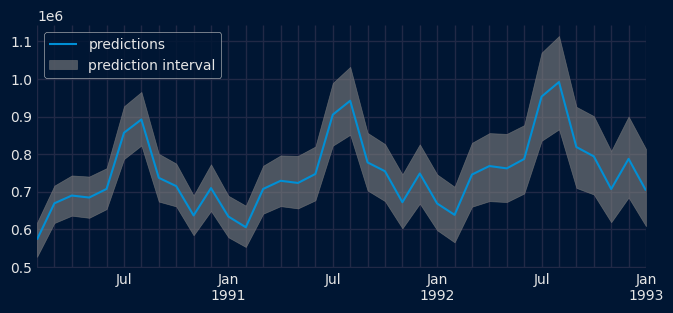

In [13]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
        predictions.index,
        predictions['lower_bound'],
        predictions['upper_bound'],
        label='prediction interval',
        color='gray',
        alpha=0.6,
        zorder=1
    )
plt.legend()
plt.show()

## Backtesting

ETS and other statistical models, once integrated in a [`ForecasterStats`](https://skforecast.org/latest/api/forecasterstats) object, can be evaluated using any of the [backtesting strategies](../introduction-forecasting/introduction-forecasting.html#backtesting-forecasting-models) implemented in skforecast.

In [14]:
# Backtesting
# ==============================================================================
forecaster = ForecasterStats(estimator=Ets(m=12, model="MAM"))

cv = TimeSeriesFold(
    initial_train_size = 150,
    steps              = 12,
    refit              = True,
)

metric, predictions = backtesting_stats(
    y               = y,
    forecaster      = forecaster,
    cv              = cv,
    interval        = [2.5, 97.5],
    metric          = 'mean_absolute_error',
    verbose         = False
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [15]:
# Backtesting metrics
# ==============================================================================
metric

,mean_absolute_error
0,17007.145392


In [16]:
# Backtest predictions
# ==============================================================================
predictions.head(4)

,fold,pred,lower_bound,upper_bound
1981-07-01,0,600527.774094,553699.342608,650166.023061
1981-08-01,0,624680.495870,573944.936678,672664.854123
1981-09-01,0,508119.826628,466613.872173,547733.573900
1981-10-01,0,483829.727321,443484.456270,523269.448938


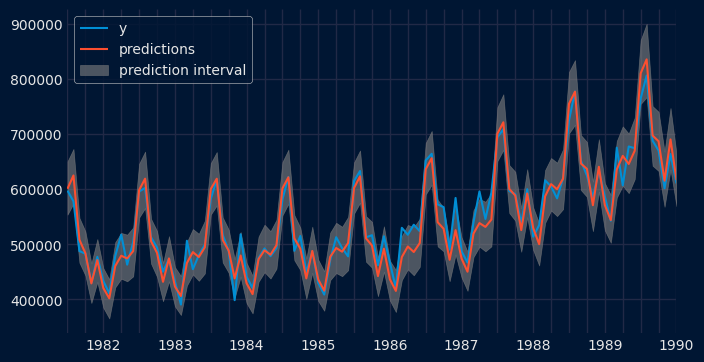

In [17]:
# Plot predictions
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 4))
y.loc[predictions.index].plot(ax=ax, label='y')
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
        predictions.index,
        predictions['lower_bound'],
        predictions['upper_bound'],
        label='prediction interval',
        color='gray',
        alpha=0.6,
        zorder=1
    )
plt.legend()
plt.show()

## Memory optimization

For production environments where you need to store many fitted models but only require forecasting capabilities (not diagnostics), you can significantly reduce memory usage with the `reduce_memory()` method. This is specially useful when working with large datasets or deploying models in resource-constrained environments.

This method removes in-sample fitted values and residuals, which are only needed for diagnostic purposes but not for generating forecasts. After calling `reduce_memory()`, the following methods of internal estimator will raise an error:

- `fitted_()`: In-sample fitted values
- `residuals_()`: In-sample residuals  
- `score()`: R² coefficient
- `summary()`: Model summary statistics

However, prediction methods remain fully functional:

- `predict()`: Point forecasts
- `predict_interval()`: Prediction intervals

In [18]:
# Compare size before and after reduce_memory()
# ==============================================================================
import sys

forecaster = ForecasterStats(estimator=Ets(m=12, model="MAM"))
forecaster.fit(y=y)

model_size_before = (
    sys.getsizeof(forecaster.estimator.fitted_values_) + 
    sys.getsizeof(forecaster.estimator.residuals_in_) +
    sys.getsizeof(forecaster.estimator.y_)
)
print(f"Memory before reduce_memory(): {model_size_before / 1024:.3f} KB")

# Reduce memory
forecaster.reduce_memory()
model_size_after = (
    sys.getsizeof(forecaster.estimator.fitted_values_) + 
    sys.getsizeof(forecaster.estimator.residuals_in_) +
    sys.getsizeof(forecaster.estimator.y_)
)
print(f"Memory after reduce_memory(): {model_size_after / 1024:.3f} KB")
print(f"Memory reduction: {(1 - model_size_after / model_size_before) * 100:.1f}%")

Memory before reduce_memory(): 4.281 KB
Memory after reduce_memory(): 0.047 KB
Memory reduction: 98.9%


In [19]:
# Predictions still work after memory reduction
# ==============================================================================
forecaster.predict(steps=10)

1990-02-01    572571.887299
1990-03-01    669143.105557
1990-04-01    689782.578808
1990-05-01    684505.532301
1990-06-01    707356.623580
1990-07-01    856921.154608
1990-08-01    892235.308195
1990-09-01    736939.828314
1990-10-01    714947.688723
1990-11-01    636906.811948
Freq: MS, Name: pred, dtype: float64